## Title: Leveraging Quadratic Polynomials in Python for Advanced Data Analysis

### Revision 1 - With Comparison and function to fit a polynomial model with Regularization and Cross-Validation

This code with regularization to prevent overfitting and cross-validation.
Ridge regression is used within the `fit_polynomial_model` function to fit the polynomial models.
The `cross_val_score function` from scikit-learn is used to perform 5-fold cross-validation.

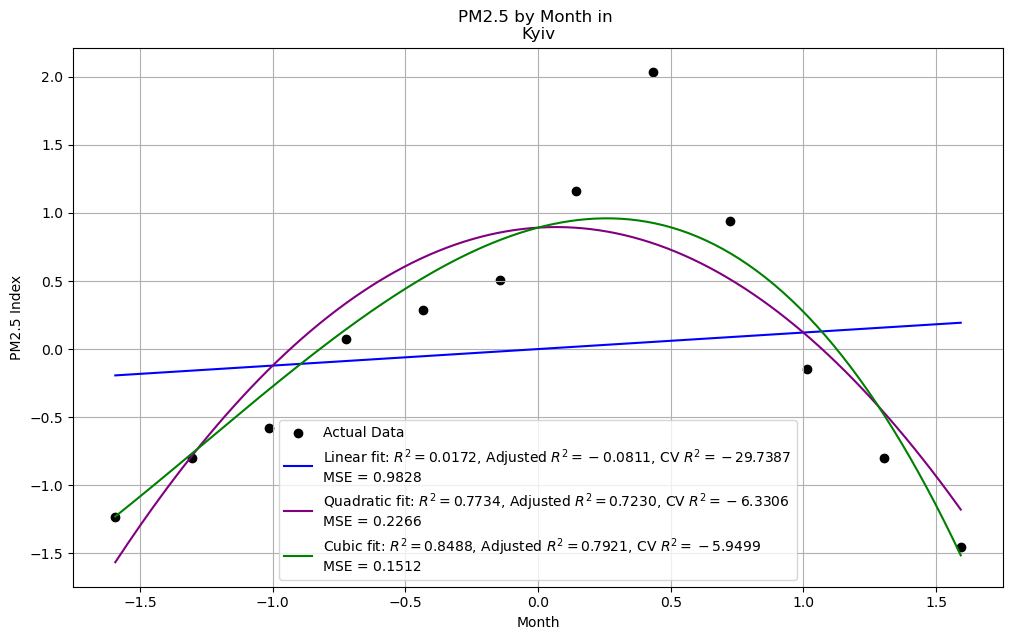

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

def handle_missing_data(data, method):
    if method == 'remove':
        data.dropna(inplace=True)
    elif method == 'mean':
        data.fillna(data.mean(), inplace=True)
    elif method == 'median':
        data.fillna(data.median(), inplace=True)
    elif method == 'ffill':
        data.fillna(method='ffill', inplace=True)
    elif method == 'bfill':
        data.fillna(method='bfill', inplace=True)
    else:
        raise ValueError("Method should be 'remove', 'mean', 'median', 'ffill', or 'bfill'")
    return data

def calculate_metrics(y_true, y_pred, degree):
    residuals = y_true - y_pred
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r_squared = 1 - (ss_res / ss_tot)
    adjusted_r_squared = 1 - (1 - r_squared) * (len(y_true) - 1) / (len(y_true) - degree - 1)
    mse = mean_squared_error(y_true, y_pred)
    return r_squared, adjusted_r_squared, mse

# User inputs for the descriptive elements of the plot
description = input("Enter the location description (e.g., Kyiv, Shcherbakovskaya St.): ")
pollution_name = input("Enter the pollution name (e.g., PM2.5): ")
y_label = input("Enter the y-axis label (e.g., PM2.5 Index): ")
missing_data_method = input("Choose how to handle missing data ('remove', 'mean', 'median', 'ffill', 'bfill'): ")

# Read data from a CSV file
data = pd.read_csv('https://raw.githubusercontent.com/rsipakov/QuadraticPolynomialsPyDA/main/notebooks/pm_data.csv')

# Handle missing data based on user choice
data = handle_missing_data(data, missing_data_method)

# Outlier Detection and Treatment using Z-Score method
z_scores = np.abs((data - data.mean()) / data.std())
data = data[(z_scores < 3).all(axis=1)]

# Extracting months and values
months = data['Month'].to_numpy()
values = data['Values'].to_numpy()

# Data Normalization using StandardScaler
scaler = StandardScaler()
months_scaled = scaler.fit_transform(months.reshape(-1, 1)).flatten()
values_scaled = scaler.fit_transform(values.reshape(-1, 1)).flatten()

# Function to fit a polynomial model with regularization and cross-validation
def fit_polynomial_model(degree, X, y):
    poly = PolynomialFeatures(degree=degree)
    model = make_pipeline(poly, Ridge(alpha=1.0))
    scores = cross_val_score(model, X.reshape(-1, 1), y, cv=5, scoring='r2')
    model.fit(X.reshape(-1, 1), y)
    y_pred = model.predict(X.reshape(-1, 1))
    r2, adjusted_r2, mse = calculate_metrics(y, y_pred, degree)
    return model, y_pred, r2, adjusted_r2, mse, scores.mean()

# Fit the linear polynomial
linear_model, linear_pred, linear_r2, linear_adjusted_r2, linear_mse, linear_cv_r2 = fit_polynomial_model(1, months_scaled, values_scaled)

# Fit the quadratic polynomial
quadratic_model, quadratic_pred, quadratic_r2, quadratic_adjusted_r2, quadratic_mse, quadratic_cv_r2 = fit_polynomial_model(2, months_scaled, values_scaled)

# Fit the cubic polynomial
cubic_model, cubic_pred, cubic_r2, cubic_adjusted_r2, cubic_mse, cubic_cv_r2 = fit_polynomial_model(3, months_scaled, values_scaled)

# Generate a smooth curve by evaluating the polynomials at many points
x = np.linspace(months_scaled.min(), months_scaled.max(), 200)
linear_y = linear_model.predict(x.reshape(-1, 1))
quadratic_y = quadratic_model.predict(x.reshape(-1, 1))
cubic_y = cubic_model.predict(x.reshape(-1, 1))

# Create the plot
plt.figure(figsize=(12, 7))

# Plot the data and the fitted curves
plt.scatter(months_scaled, values_scaled, color='black', label='Actual Data')
plt.plot(x, linear_y, color='blue', label=f'Linear fit: $R^2 = {linear_r2:.4f}$, Adjusted $R^2 = {linear_adjusted_r2:.4f}$, CV $R^2 = {linear_cv_r2:.4f}$\nMSE = {linear_mse:.4f}')
plt.plot(x, quadratic_y, color='purple', label=f'Quadratic fit: $R^2 = {quadratic_r2:.4f}$, Adjusted $R^2 = {quadratic_adjusted_r2:.4f}$, CV $R^2 = {quadratic_cv_r2:.4f}$\nMSE = {quadratic_mse:.4f}')
plt.plot(x, cubic_y, color='green', label=f'Cubic fit: $R^2 = {cubic_r2:.4f}$, Adjusted $R^2 = {cubic_adjusted_r2:.4f}$, CV $R^2 = {cubic_cv_r2:.4f}$\nMSE = {cubic_mse:.4f}')

# Title and labels using user inputs
plt.title(f'{pollution_name} by Month in \n{description}')
plt.xlabel('Month')
plt.ylabel(y_label)

# Add legend and grid
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
